In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import iisignature

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import trange

In [3]:
# period
start_date = "2010-01-01"
end_date = "2026-01-01"

# universe
tickers = {
    "S&P 500": "^GSPC",
    "DJIA": "^DJI",
    "Nasdaq": "^IXIC",
    "Apple": "AAPL",
    "Nvidia": "NVDA"
}

# download from yfinance
prices = yf.download(
    list(tickers.values()), start=start_date, end=end_date, 
    auto_adjust=False, progress=False)["Close"]

logret = np.log(prices).diff().dropna()

Model the log return process as,

$$
X_t =  \underbrace{\mu(\mathcal{S}(X)) dt}_{\text{drift term}} + \underbrace{\sigma_t dW_t}_{\text{residual term}}
$$

where $X_t$ represents log returns from time $t-dt$ to $t$.

Path generation idea:
- Estimate and predict the drift term with KRR regression (parametric)
- Estimate and predict the residual with KNN using signature as feature space (non-parametric)

In [40]:
def build_krr_dataset(log_rets, lookback, sig_level, dt):
    x_sig = []   # signatures of log return windows
    y_drift = []  # drift term
    times  = np.arange(lookback)*dt
    for log_r in log_rets:
        for i in range(lookback, len(log_r)):
            window = log_r[i-lookback:i]
            path2d = np.stack([times, window], axis=1)
            # signatures
            sig = iisignature.sig(path2d, sig_level)
            x_sig.append(sig)
            # drift target
            y_drift.append(log_r[i]/dt)

    x_sig  = np.vstack(x_sig) # (num_windows, sig_dim)
    y_drift = np.array(y_drift)
    return x_sig, y_drift

def train_kernel_ridge(S, y, lam):
    # (K + lam I) alpha = y
    K = S @ S.T
    alpha = np.linalg.solve(K + lam*np.eye(K.shape[0]), y)
    return alpha, S

def krr_predict(alpha, S_train, sig_new):
    k = S_train @ sig_new
    return (k @ alpha).item()

def build_hybrid_library(log_rets, lookback, sig_level, dt, lam):
    # lam: regularization coef for KRR

    x_sig, y_drift = build_krr_dataset(log_rets, lookback, sig_level, dt)
    alpha, _ = train_kernel_ridge(x_sig, y_drift, lam)
    residuals_list = []
    times  = np.arange(lookback)*dt
    for log_r in log_rets:
        for i in range(lookback, len(log_r)):
            window = log_r[i-lookback:i]
            path2d = np.stack([times, window], axis=1)
            sig = iisignature.sig(path2d, sig_level)

            drift = krr_predict(alpha, x_sig, sig)
            resid = log_r[i] - drift*dt
            residuals_list.append(resid)
    
    return alpha, x_sig, np.array(residuals_list)

def generate_path_hybrid(seed_path, n_total_steps, lookback, sig_level, dt, alpha, library_sigs, library_residuals, k=10):
    gen_path_list = list(seed_path)
    times  = np.arange(lookback)*dt
    for i in range(n_total_steps - len(seed_path)):
        past_segment = gen_path_list[-lookback:]
        path2d = np.stack([times, past_segment], axis=1)
        q_sig = iisignature.sig(path2d, sig_level)

        # predict drift
        drift = krr_predict(alpha, library_sigs, q_sig)
        # predict residual
        distances = np.linalg.norm(library_sigs - q_sig, axis=1)
        neighbor_indices = np.argsort(distances)[:k]             # find the K-nearest neighbors
        chosen_neighbor_idx = np.random.choice(neighbor_indices) # randomly choose one from the K-nearest neighbors
        resid = library_residuals[chosen_neighbor_idx]
        
        # generate next value
        next_val = drift*dt + resid
        gen_path_list.append(next_val)
    
    return np.array(gen_path_list)[len(seed_path):n_total_steps]

In [ ]:
ticker = "^GSPC"
train_start = "2010-01-01"
train_end = "2024-12-31"
#test_end = "2025-06-30"

LOOKBACK = 60
FORWARD = 5
NSIM = 100
SIG_LEVEL = 3
FREQ = 1

X_train = logret.loc[train_start:train_end, ticker].values
X_seed = X_train[-LOOKBACK:]
#X_test = logret.loc[train_end:test_end, ticker].values[1:]

In [41]:
alpha, library_sig, library_resid = build_hybrid_library([X_train], LOOKBACK, sig_level=3, dt=1, lam = 0.1)

In [ ]:
# generate path for future 1 week
X_gens = []
for _ in trange(NSIM):
    X_gens.append(
        generate_path_hybrid(
            X_seed, n_total_steps=LOOKBACK+len(5), lookback=LOOKBACK, sig_level=SIG_LEVEL, 
            dt=FREQ, alpha = alpha, library_sigs=library_sig, library_residuals=library_resid, k=10)
    )

100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


In [ ]:
Y0 = prices.loc[train_end, ticker]
#Y_test = Y0 * np.exp(X_test.cumsum())
Y_gens = []
for i in range(NSIM):
    Y_gens.append(Y0 * np.exp(X_gens[i].cumsum()))

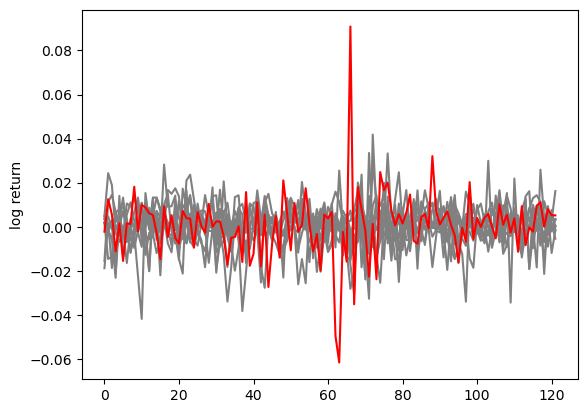

In [44]:
for path in X_gens[:10]:
    plt.plot(path, color = 'grey', label = 'generated')
plt.plot(X_test, color = 'red', label = 'realized')
plt.ylabel("log return")
plt.show()

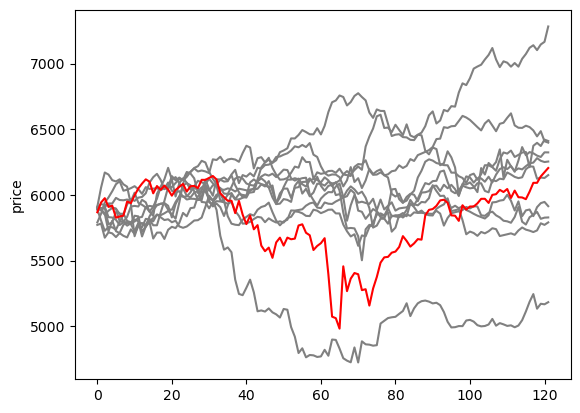

In [45]:
for path in Y_gens[:10]:
    plt.plot(path, color = 'grey', label = 'generated')
plt.plot(Y_test, color = 'red', label = 'realized')
plt.ylabel("price")
plt.show()